# Hyperparameter Optimization for MNIST Digit Classifcation

Most machine learning models have some parameters that you can play around with. We saw this last week with ridge regression. We were able to choose the value of $\lambda$ in order to get our model to behave differently. However one may ask the question, how do we know the best $\lambda$ for our model? This often depends on many factors and is model dependent. We will be answering this question for a different set of hyper parameters for a different model.

In this notebook, we will be using various different tools we have learned in past weeks and explore how to optimize their hyper parameters.

We will be importing a python module that includes the MNIST handwritten digit dataset for us. In addition we will use skleran's MLPClassifier as our MLP.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import random

Now we load the data, which is already split into training and testing for us

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

It is always a good idea to attempt to visualize data before performing any sort of ML techniques on it. Let us choose a few random indices and display the handwritten digits using the plt.imshow function.

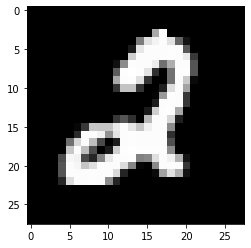

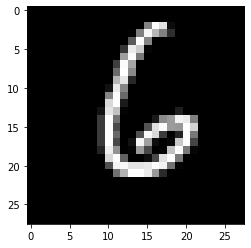

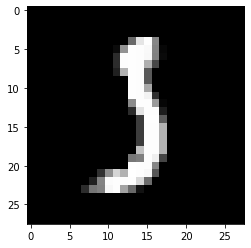

In [3]:
imgplot = plt.imshow(train_X[381], cmap = 'gray')
plt.figure()
imgplot = plt.imshow(train_X[32], cmap = 'gray')
plt.figure()
imgplot = plt.imshow(train_X[132], cmap = 'gray')

To start off, let us take a scenario where we only wish to classify between a handwritten '0' and '1'. So, for this code, we wish to populate the variables $train\_X\_bin, train\_y\_bin, test\_X\_bin, test\_y_bin$. We want them to be similar to the original testing/training data with the following exception:

We want to omit all data points with labels that are not 0 or 1. We also wish to vectorize the images. The structure of the given data is N x 28 x 28, or N (28 x 28) pictures. Instead, we wish to represent each picture, which is just a 2D array of ints, as a flattened 1d array of ints. So, the dimensionality of our new data should be M x $28^2$ and M is definitely smaller than N. 

### **(TODO) Create a new set of training/testing data that only contains images with labels 0 or 1. Furthermore, flatten the images into 1D arrays of size 28*28**. Store the new test/train split for X and y in the variables defined below. (Hint: numpy's reshape library may come in handy for the image flattening).

In [4]:
train_X_bin, train_y_bin = [], []
test_X_bin, test_y_bin = [], []

#TODO
#Start
for i in range(len(train_X)):
    label = train_y[i]
    if label == 0 or label == 1:
        train_X_bin.append(train_X[i])
        train_y_bin.append(2 * train_y[i] - 1)
        
for i in range(len(test_X)):
    label = test_y[i]
    if label == 0 or label == 1:
        test_X_bin.append(test_X[i])
        test_y_bin.append(2 * test_y[i] - 1)
        
train_X_bin = np.array(train_X_bin)
train_y_bin = np.array(train_y_bin, dtype=int)
test_X_bin  = np.array(test_X_bin)
test_y_bin  = np.array(test_y_bin, dtype=int)
train_X_bin = train_X_bin.reshape(train_X_bin.shape[0], train_X_bin.shape[1] * train_X_bin.shape[2])
test_X_bin = test_X_bin.reshape(test_X_bin.shape[0], test_X_bin.shape[1] * test_X_bin.shape[2])
#End

# MNIST: Ridge Classifer

Now we will try various different machine learning aproaches to classify the handwritten digits. For each of these ML techniques, we will introduce a hyper parameter and have you find the best hyper parameter. Let us start with ridge regression.

We have used ridge regression before, but let's remind ourselves how it works. Say we have a data matrix $X \in \mathbb{R}^{n \times d}$. In our case, $n$ is the number of training data for the '0' or '1' handwritten digits. Each image is $28 \times 28$ pixels, which means that $d = 28^2 = 784$. Our labels will be stored in a vector $\vec{y} \in \mathbb{R}^n$ where $y_i \in \{0, 1\}$. In ridge regression, we solve the following optimization problem: 

$$
\min_{\vec{w} \in \mathbb{R}^d} ||(X\vec{w} - \vec{y})||_2^2 + \lambda ||\vec{w}||_2^2, \; \; \lambda > 0
$$
Where the solution to this optimization problem is $\vec{w}^* = (X^TX + \lambda I)^{-1}X^T\vec{y}$. If we wish to classify a new datapoint $\vec{x_{new}}$, then we use the folowing scheme: $label_{new} = f(\vec{x_{new}}^T \vec{w}^*)$ where $f(x) = 1$ if $x > 0$ and $f(x) = 0$ if $x \le 0$. Now that we have covered how we will use ridge regression to classify new samples, let us impliment a few helper functions.

### **(TODO) Impliment the function loss_func code. This loss function will simply return the percentage of missclassified datapoints given a test data matrix X_test, the optimal weight w_opt, and the reference labels y_ref (HINT: Use the previous functions).**

In [5]:
def loss_func(y_pred, y_ref):
    #TODO
    #Start
    err_vec = (y_pred - y_ref) ** 2
    return np.sum(err_vec) / len(err_vec)
    #End

### **(TODO) Impliment the classify function. Upon a scalar input, classify(x) will return the sign of x. On a vector input, classify(x) returns the sign of each element of the vector.**

In [6]:
def classify(x):
    #TODO
    #Start
    return 2*(x >= 0).astype(int) - 1
    #End

### **(TODO) Impliment the classify_ridge function. This function will take in the train/test data along with the ridge hyper parameter. It should return the classification test error. You can use Sklearn's ridge model.**

In [7]:
def classify_ridge(X_train, y_train, X_test, y_test, lambd):
    #TODO
    #Start
    ridge = Ridge(alpha=lambd, solver='cholesky')
    ridge.fit(X_train, y_train)
    y_pred = classify(ridge.predict(X_test))
    return loss_func(y_pred, y_test)
    #End

So we have a ridge classification function. Now, impliment a hyper-parameter grid search over the powers of 10 to find the most optimal value of lambda. We will provide the range of exponents. If the exponent is 4, then $\lambda = 10^4$.


### **(TODO) Given the EMPTY lists of lambdas and errors, iterate through all the lambdas (powers of exponents given) and populate the lambdas and errors lists. We will use these later for plotting.**

In [8]:
#TODO
lambdas = []
errors  = []
lambda_vals = np.logspace(-1, 12, 1)
#Start
for lambd in lambda_vals:
    loss = classify_ridge(X_train=train_X_bin, y_train=train_y_bin, X_test=test_X_bin, y_test=test_y_bin, lambd=lambd)
    lambdas.append(lambd)
    errors.append(loss)
#End

Now we will plot the different values of lambda with their respective errors.

### **(TODO) Plot the values of lambda against the log of the errors**

Text(0.5, 1.0, 'Log Lambda vs Log Error')

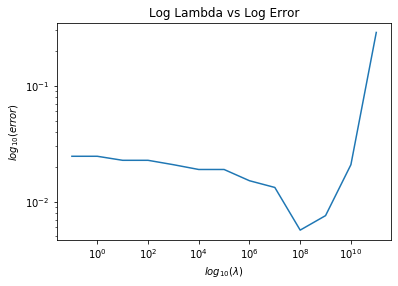

In [9]:
#TODO
#Start
plt.loglog(lambda_vals, errors)
plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('$log_{10}(error)$')
plt.title('Log Lambda vs Log Error')
#End

### **(TODO) Given the plot above, what is the most optimal value of lambda? What is the associated error? Remember that this error is the percentage of miss-classified test points. Would you consider ridge regression to be a good binary classifer?**

COMMENT HERE

Based on the minimizer that we have coded, $\lambda^* \approx 10^8$ and $error \approx 10^{-2.25} \approx 0.56\%$. Using this value of lambda, ridge regression for MNIST binary classification works great!

# MNIST: Logistic Regression With a Twist

Now we will perform the same sort of classification, except we will use logistic regression. With a twist. Before we get to the twist, let us perform the standard logistic regression. You may use sklearn's logistic regression functionality. Remember, we are classifying on the following variables:

$$train\_X\_bin, train\_y\_bin, test\_X\_bin, test\_y\_bin$$


### **(TODO) Perform logistic regression on the MNIST data. Sklearn's LogisticRegression model may be useful here. Make sure to use  LogisticRegression(penalty = 'none', solver='saga')**

In [10]:
#TODO
#Start
logreg = LogisticRegression(penalty='none', solver='saga')
logreg.fit(train_X_bin, train_y_bin)
#End

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

### **(TODO) Report the training and testing error. You can re-use the loss_func function from before .** 

In [11]:
#TODO
#Start
train_y_pred = logreg.predict(train_X_bin)
test_y_pred  = logreg.predict(test_X_bin)

train_error = loss_func(train_y_pred, train_y_bin)
test_error = loss_func(test_y_pred, test_y_bin)
#End

print('Training Error:', train_error)
print('Testing  Error:', test_error)

Training Error: 0.0
Testing  Error: 0.0018912529550827422


### **(TODO) Comment on how well logistic regression performs on binary MNIST digit classification**

COMMENT

Logistic regression works very well on the handwritten digits. The training is near perfect and the testing only has a mislcassifcation rate of 0.2%

Seeing how logistic regression performs so well, we will not try our best to make it perform worse. The way we will do this is to add noise to the training data. We will then see how well it performs at different noise levels.

Some background first: We can model noise by simply adding small random numbers to each entry of our matrices. There is much theory behind how to model this noise using random variables, but we will not dive into this. We will provide you with the code that adds noise to the data. The one thing you must understand is that we will be using a parameter, named sigma, that will control the level of noise added. 

To get a feel for this, let us first plot a simple sine wave without any added noise

Text(0.5, 1.0, 'Simple Sine Wave')

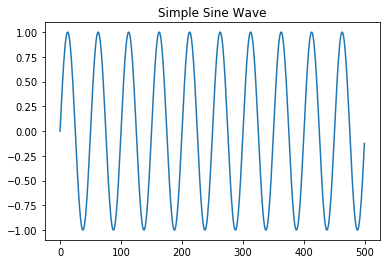

In [12]:
t = np.arange(500)
plt.plot(t, np.sin(10 * 2 * np.pi * t / len(t)))
plt.title('Simple Sine Wave')

Now that we have plotted a sine wave, we will add noise to it with this parameter we have mentioned before, sigma. We want you to play around with sigma. Try differnt values of sigma and run the cell below. This will give you a feel for how this parameter changes added noise. Do note that $\sigma \ge 0$. You should specifically try values between 0 and 1

### **(TODO) Play around with sigma to get a feel for how noise effects the data.** 

Text(0.5, 1.0, 'Noisy Sine Wave $\\sigma=$0.2')

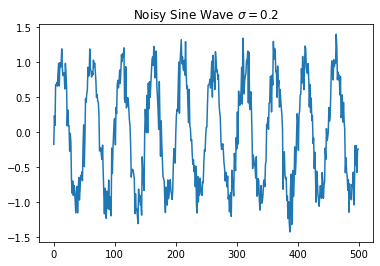

In [13]:
#Try different sigma values 0 - 1
#Start
sigma = 0.2
#End

noisy_sine = np.sin(10 * 2 * np.pi * t / len(t)) + np.random.normal(0, sigma, len(t))
plt.plot(t, noisy_sine)
plt.title('Noisy Sine Wave $\sigma=$' + str(sigma))

Now, we will do the same thing for our datasets. First, we will create a function that will automatically return a new set of data with noise X samples:

In [14]:
def noisy_data(X_train, X_test, sigma):
    X_train_noisy = X_train + np.random.normal(0, sigma, X_train.shape)
    X_test_noisy  = X_test  + np.random.normal(0, sigma, X_test.shape)
    return X_train_noisy, X_test_noisy

We also need a function to convert the 1D flattened images back to 2D. This you will impliment:

### **(TODO) Impliment the function vec_to_img which takes in a 1d array and the image resolution. It will return a 2d array that represents the image.** 

In [15]:
def vec_to_img(vec, res):
    #TODO
    #Start
    return vec.reshape(res)
    #End

Now let us define our new noisy dataset. We will be plotting a few handwritten digits. We encourage you to again play with sigma and see how the images turnout:

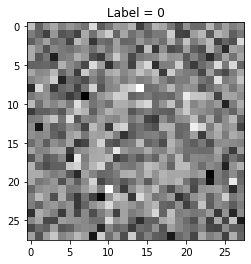

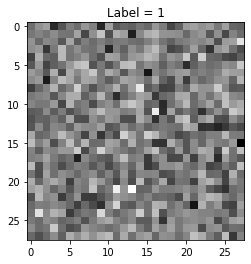

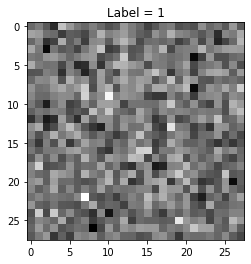

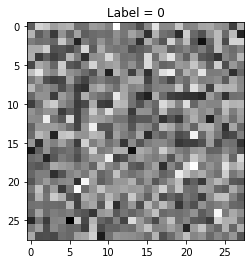

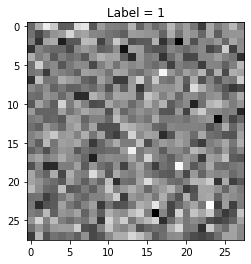

<Figure size 432x288 with 0 Axes>

In [16]:
#Try different sigma values in the range 0-400
#Start
sigma = 400
#End
X_train_noisy, X_test_noisy = noisy_data(train_X_bin, test_X_bin, sigma)

random_indices = random.sample(range(0, X_train_noisy.shape[0] - 1), 5)
for i in random_indices:
    imgplot = plt.imshow(vec_to_img(X_train_noisy[i], (28, 28)), cmap = 'gray')
    plt.title('Label = ' + str((train_y_bin[i] + 1) // 2))
    plt.figure()

Now we will see how logistic regression performs at different values of sigma. We will provide you a range of sigma values: $\sigma \in [0, 100]$. We would like you to populate the list $err\_lst$. For each value of sigma, find the error and update the list:

### **(TODO) Go through all the values of sigma in sigmas. Populate the list err_lst with the error on the test data for a specific value of sigma. Use loss_func to compute the error.** 

In [17]:
sigmas = np.arange(350,400)
err_lst = []
#TODO
#Start
logreg = LogisticRegression(penalty='none', solver='saga')
for sigma in sigmas:
    #Generate the noisy data
    X_train_noisy, X_test_noisy = noisy_data(train_X_bin, test_X_bin, sigma)
    #Fit the logistic regressor
    logreg.fit(X_train_noisy, train_y_bin)
    #predict
    y_pred = logreg.predict(X_test_noisy)
    #find and store the error
    err_lst.append(loss_func(y_pred, test_y_bin))
#End

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\program

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\program

### **(TODO) Now plot the error as a funtion of sigma below.**

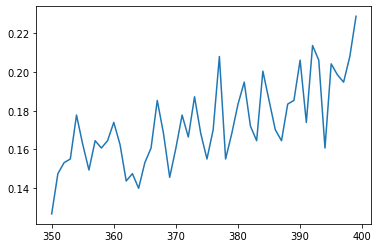

In [18]:
#TODO
#Start
plt.plot(sigmas, err_lst)
#End

We can see the error start creeping up, as expected. So, we will try to combat this by introducing a hyperparameter for regularization. Just like in ridge regression where we used lambda, logistic regression also has a regularization hyper parameter. We will be using the L2 regularizer to see if we can achieve better results at high error.

Let us first show you how to use the regularizer with Sklearn's regressor:

In [19]:
c = 23.0
logreg = LogisticRegression(random_state=0, penalty = 'l2', solver='saga')
logreg.set_params(C=c)

LogisticRegression(C=23.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Here, the parameter $c$ is used as the hyper parameter to control the L2 regularization. The larger $c$ is, the smaller the regularization is. That is, $c$ is inversley proportional to the amount of regularization (unlike ridge regression).  

So, we will now use $\sigma = 400$ and try different values of $C$.

### **(TODO) Perform hyper parameter optimization via grid search. Use sigma = 400 and try all values of C within the range specified. Store the error in err_lst for each value of C**

In [20]:
Cs = np.logspace(-15, -1, 10)
err_lst = []
X_train_noisy, X_test_noisy = noisy_data(train_X_bin, test_X_bin, sigma=400)
logreg = LogisticRegression(random_state=0, penalty = 'l2', solver='saga', C=c)
#TODO
#Start
for c in Cs:  
    #Set the parameter
    logreg.set_params(C=c)
    #Fit the logistic regressor
    logreg.fit(X_train_noisy, train_y_bin)
    #predict
    y_pred = logreg.predict(X_test_noisy)
    #find and store the error
    err_lst.append(loss_func(y_pred, test_y_bin))
#End

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### **(TODO) Plot the error against the different values of C.**

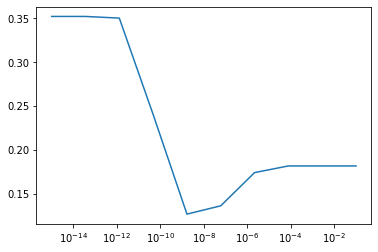

In [21]:
#TODO
#Start
plt.semilogx(Cs, err_lst)
#End

### **(TODO) Which value of C is the best? What is the associated error?.**

COMMENT

C should be on the order of $10^{-8}$ and the associated error should be around 0.15.

### **(TODO) Is this minimum error better than the error without regularization? .**
o
COMMENT

Yes, we achieved a lower error using the right hyper parameter! 

# MNIST: Least Squares - PCA

We will finally use Least Squares in combination with PCAs. Let us mathematically define our model:

$$\min_{\vec{w} \in \mathbb{R}^d} ||X_k\vec{w} - \vec{y}||_2^2,\; \; X_k = XV_kV_k^T, \; \; X = U \Sigma V^T$$

We define $V_k$ to be the first $k$ columns of $V$. In this problem, k is our hyper parameter. Then, to classify, we use:

$$
    PCA_k(X_{new}) \vec{w}^* = X_{new}V_{k,new} V_{k,new}^T \vec{w}^*
$$

We wish to explore which value of k will yield us the best results.

First, we need a least squares function and a PCA funtion. You can use Sklearn's implimentation of each.

### **(TODO) Impliment the least_sq_pca_train function. This will perform least squares on the k dimensional representation of the data matrix X. Return the weight vector and the training error**

In [22]:
def least_sq_pca_train(X_train, y_train, k):
    #TODO
    #Start
    pca = PCA(n_components=k)
    pca.fit(X_train)
    Xk = pca.transform(X_train)
    w = np.linalg.lstsq(Xk, y_train,rcond=None)[0]
    y_pred = Xk @ w
    train_err = loss_func(y_pred, y_train)
    #End
    return w, train_err

### **(TODO) Impliment the least_sq_pca_test function. This will first perform k-PCA on the test data, then multiplies the k-PCA test data with the optimal vector w. Report the predicted value and the testing error**

In [23]:
def least_sq_pca_test(X_test, y_test, w, k):
    #TODO
    #Start
    pca = PCA(n_components=k)
    pca.fit(X_test)
    Xk = pca.transform(X_test)
    y_pred = Xk @ w
    test_err = loss_func(y_pred, y_test)
    #End
    return y_pred, test_err

Now we will apply the functions to the training and testing data for k = 2:

### **(TODO) Using our two helper functions, perform least square-pca classification on the training set to find w, then report the training error. Then find the testing error using the test set.**

In [24]:
k = 2
#TODO
#Start
w, train_err = least_sq_pca_train(train_X_bin, train_y_bin, k = k)
y_pred, test_err = least_sq_pca_test(test_X_bin, test_y_bin, w, k = k)
#End
print(str(k) + '-PCA Training Error:', train_err)
print(str(k) + '-PCA Testing Error:', test_err)

2-PCA Training Error: 0.1115892523533677
2-PCA Testing Error: 0.10813611281700732


Now (hopefully we are seeing a pattern by now) we want to use hyper-parameter grid search in order to find the best k. We have provided the range of Ks for you to use. 

### **(TODO) Iterate through all values of k in the range in order to find the testing error at each value of k. Store this testing error into the list err_lst**

In [25]:
ks = range(1, 784, 100)
err_lst = []
#TODO
#Start
for k in ks:
    w, train_err = least_sq_pca_train(train_X_bin, train_y_bin, k = k)
    y_pred, test_err = least_sq_pca_test(test_X_bin, test_y_bin, w, k = k)
    err_lst.append(test_err)
#End

### **(TODO) Plot the values of k vs the err_lst**

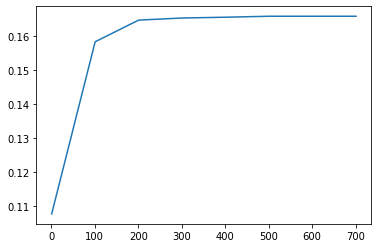

In [26]:
#TODO
#Start
plt.plot(ks, err_lst)
#End

It seems that the best values of k happen in the beginning. Let us 'thin the herd' and change the range from (1, 100, 5)

### **(TODO) Copy what you have done for the previous part, this time the range is slightly different**

In [27]:
ks = range(1, 100, 10)
err_lst = []
#TODO
#Start
for k in ks:
    w, train_err = least_sq_pca_train(train_X_bin, train_y_bin, k = k)
    y_pred, test_err = least_sq_pca_test(test_X_bin, test_y_bin, w, k = k)
    err_lst.append(test_err)
#End

### **(TODO) Plot the values of k vs the err_lst (Copy from before)**

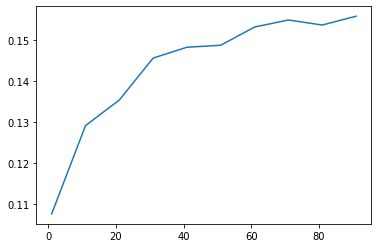

In [28]:
#TODO
#Start
plt.plot(ks, err_lst)
#End

It seems like we still need to narrow our focus down to everything below 20. Let us change the range yet again:

### **(TODO) Copy what you have done for the previous part, this time the range is slightly different**

In [29]:
ks = range(1, 20, 1)
err_lst = []
#TODO
#Start
for k in ks:
    w, train_err = least_sq_pca_train(train_X_bin, train_y_bin, k = k)
    y_pred, test_err = least_sq_pca_test(test_X_bin, test_y_bin, w, k = k)
    err_lst.append(test_err)
#End

### **(TODO) Plot the values of k vs the err_lst (Copy from before)**

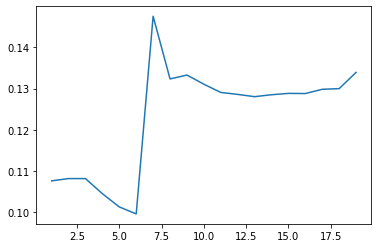

In [30]:
#TODO
#Start
plt.plot(ks, err_lst)
#End

And finally, we can see where our best performance happens! 

### **(TODO) Report the best value of k and the corresponding error**

COMMENT

The best value of k should be around 6 and the best error is around 10%

Notice the technique we used here. We used a grid search, but we did split it into multiple smaller grid searches. We broke it down into k = 1, 101, 201, ... 701 then we did k = 1, 11, 21, ... 91 then finally we did k = 1, 2, 3, ... 20. 

However, this 'augmented' grid search has it's advantages and disadvantages. Please list the pros and cons of this augmented grid search:

### **(TODO) Augmented grid search pros:**

COMMENT HERE

We are able to reach a minimum in a very small amount of time. We broke the problem into sizable chunks that were not very time consuming.

### **(TODO) Augmented grid search cons:**

COMMENT HERE

The biggest con to this is that we are assuming that there are no 'dips' in our graph. What we mean by 'dips' are any sharp drops in error. If there are dips, then iterating over every 100 hyperparemeter values may completeley jump over the dip.